<a href="https://colab.research.google.com/github/saeedkargar/Keras_Deep_Clustering/blob/master/HEX_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy
from matplotlib.pyplot import imread
import skimage.transform
from cv2 import imshow
import imageio
import cv2
import os
import time
import scipy
import random

In [4]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.datasets import cifar10

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [6]:
number_of_samples = 10000#len(x_train)
x_train_1 = x_train[:number_of_samples]
x_test_1 = x_test[:number_of_samples]

In [7]:
height = x_train_1[0].shape[0] 
width = x_train_1[0].shape[1]

def filter_images(images):
    image_list = []
    for image in images:
        image_list.append(image)
    return image_list


# convert Image into Byte array
def to_bytes(image_list, height, width):
    hash_ds = []
    bytes_ds = []
    for image in image_list:
        row_res = cv2.resize(image,(height, width), interpolation = cv2.INTER_AREA).flatten() 
        ds = np.vstack((row_res)).flatten()
        temp = bytearray(ds)
        hash_ds.append(ds)
        bytes_ds.append(temp)
    return hash_ds, bytes_ds


def to_bits(bytes_as_bits_1):
    list1 = []
    sublist = []
    listofbits = []
    listoflists = []
    listoflists_original = []
    list1 = bytes_as_bits_1
    whole_list = [[] for i in range(len(list1))]  
    for i in range(len(list1)):
      [whole_list[i].append(list1[i])]
    # each item is broken into bits
    for i in range(len(whole_list)):
      listofbits = []
      for item in whole_list[i]:
        sublist = []
        for j in range(len(item)):
          sublist.append(item[j])
        listofbits.append(sublist)
      listoflists_original.append(listofbits[0])
      for i in range(0, len(listofbits[0])):
        listofbits[0][i] = int(listofbits[0][i])
      listoflists.append(listofbits[0])
    return listoflists_original, listoflists


def hamdist(str1, str2):
  diffs = 0
  minimum = min(len(str1), len(str2))
  for i in range(minimum):
      if str1[i] != str2[i]:
        diffs += 1
  maxim = str1 if (len(str1) > len(str2)) else str2
  for j in range(minimum, len(maxim)):
    if maxim[j] == '1':
      diffs += 1
  return diffs,len(maxim)



print("Start converting!")
image_train_1d_1, train_bits_1 =to_bytes(x_train_1,height,width)
bytes_as_bits_1 = []
print("iamges to bits!")
for bytess in train_bits_1:
  bytes_as_bits_1.append( ''.join(format((byte), '08b') for byte in bytess))

Start converting!
iamges to bits!


In [8]:
listoflists_original, listoflists = to_bits(bytes_as_bits_1)
size_of_each_fig = len(bytes_as_bits_1[0])
offset = 80 * (len(listoflists)) // 100 
listoflists_numpy = np.array(listoflists)
listoflists2 = copy.deepcopy(listoflists)

In [9]:
memory_old = listoflists2[:offset]
new_data = listoflists2[offset:]

In [12]:
from keras.datasets import mnist
import numpy as np
np.random.seed(10)
from time import time
import keras.backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
from keras.layers import Layer
#from keras import metrics
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose

In [13]:
# from keras.datasets import mnist

# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# x = np.concatenate((x_train, x_test))
# y = np.concatenate((y_train, y_test))
# x = x.reshape(x.shape + (1,))
# x = np.divide(x, 255.)

In [14]:
print(len(memory_old[0]))
x = listoflists_numpy

6272


# Model to train clustering and autoencoder at same time(Fully connected)


Multiple outputs model.

In [17]:
from time import time
import numpy as np
import keras.backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
from keras.models import Model
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
import numpy as np
from keras.datasets import mnist
import numpy as np
np.random.seed(10)

In [18]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# x = np.concatenate((x_train, x_test))
# y = np.concatenate((y_train, y_test))
# x = x.reshape((x.shape[0], -1))
# x = np.divide(x, 255.)
# n_clusters = len(np.unique(y))
x.shape

(10000, 6272)

In [19]:
class ClusteringLayer(Layer):
    """
    https://github.com/Tony607/Keras_Deep_Clustering
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=15))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [20]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [21]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [22]:
dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(learning_rate=1, momentum=0.9)
pretrain_epochs = 300
batch_size = 256
n_clusters = 10
save_dir = './results'

In [23]:
autoencoder, encoder = autoencoder(dims, init=init)

In [24]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
# autoencoder.save_weights(save_dir + '/ae_weights.h5')

Epoch 1/300
40/40 [==============================] - 4s 19ms/step - loss: 0.1178
Epoch 2/300
40/40 [==============================] - 1s 18ms/step - loss: 0.0970
Epoch 3/300
40/40 [==============================] - 1s 18ms/step - loss: 0.0797
Epoch 4/300
40/40 [==============================] - 1s 18ms/step - loss: 0.0794
Epoch 5/300
40/40 [==============================] - 1s 17ms/step - loss: 0.0793
Epoch 6/300
40/40 [==============================] - 1s 18ms/step - loss: 0.0793
Epoch 7/300
40/40 [==============================] - 1s 18ms/step - loss: 0.0792
Epoch 8/300
40/40 [==============================] - 1s 17ms/step - loss: 0.0791
Epoch 9/300
40/40 [==============================] - 1s 17ms/step - loss: 0.0788
Epoch 10/300
40/40 [==============================] - 1s 17ms/step - loss: 0.0780
Epoch 11/300
40/40 [==============================] - 1s 17ms/step - loss: 0.0767
Epoch 12/300
40/40 [==============================] - 1s 17ms/step - loss: 0.0755
Epoch 13/300
40/40 [=====

In [25]:
# autoencoder.load_weights(save_dir+'/ae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,
            outputs=[clustering_layer, autoencoder.output])

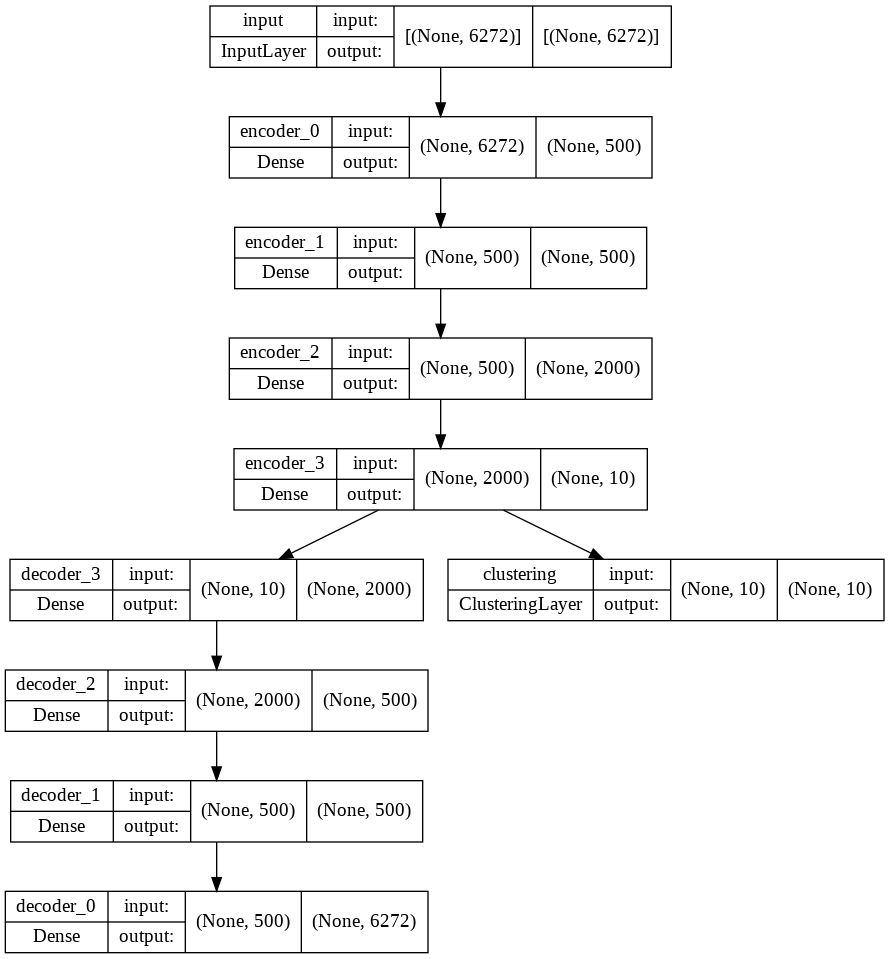

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

# Initialize cluster centers using k-means

In [27]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

In [28]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)

# Hyper-params

In [29]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])
tol = 0.001 # tolerance threshold to stop training

# Load the clustering model trained weights

In [30]:
# model.load_weights(save_dir + '/b_DEC_model_final.h5')

# Final Evaluation

In [31]:
import time
import timeit

TF_dynamic_ham = []
change_points = []
LY_FNW = []
LY_DCW = []
Total_time = []
TF_x_cluster = []
TF_y_cluster = []

##########################K-means clustering #################################

def Kmeans(listoflists, number_of_clusters, hamOUR):
  model = KMeans(n_clusters = number_of_clusters, random_state= 42)
  
  start_our = timeit.timeit()
  model.fit(encoder.predict(x[:offset]))
  end_our = timeit.timeit()
  temp1 = abs(end_our - start_our) * 1000000 /len(new_data) # ave time for each item in us
   
  ##########################K-means clustering #################################

  #################creating sample dataset for training phase#############

  
  list_of_clusters = [[] for i in range(number_of_clusters)]
  new_labels = model.labels_
  for place in range(len(memory_old)):
    list_of_clusters[new_labels[place]].append(memory_old[place])
  start_our = time.time()
  new_data_labels = model.predict(encoder.predict(x[offset:]))
  end_our = time.time()
  temp2 = (end_our - start_our) *1000000 /len(new_data) # ave time for each item in us
  temp = temp1 + temp2
  Total_time.append(temp)

  ########################################################################
  average_ham_dist = 0
  Whole_Hamming_distance = 0

  indecies = [0] * (number_of_clusters)
  times = [0] * (number_of_clusters)
  for index in range(len(new_data)):
    places = list_of_clusters[new_data_labels[index]]
    if indecies[new_data_labels[index]] >= len(places):
      indecies[new_data_labels[index]] = 0
      times[new_data_labels[index]] += 1
      if (0 not in times):
        change_points.append(index)
        indecies = [i * 0 for i in indecies]
        times = [i * 0 for i in times]
    place = places[indecies[new_data_labels[index]]]  
    place = random.choice(list_of_clusters[new_data_labels[index]])
    list_of_clusters[new_data_labels[index]][indecies[new_data_labels[index]]] = new_data[index]
    indecies[new_data_labels[index]] += 1
    
    ham_dis_our, length = hamdist(new_data[index], place)
    Whole_Hamming_distance += ham_dis_our
    TF_dynamic_ham.append(ham_dis_our)

  average_ham_dist = (Whole_Hamming_distance)/len(new_data)
  TF_y_cluster.append(average_ham_dist)
  print("The average number of bit flips per item (in percent) =  {x:.2f}%".format(x= 100 * average_ham_dist/size_of_each_fig))
  return average_ham_dist

average_ham_dist = []
rc = []
cluster_range = [5,10,15,20,25,30]
for number_of_clusters in cluster_range:
  print("number of clusters: ", number_of_clusters)
  y = Kmeans(listoflists, number_of_clusters,average_ham_dist)
  print("=============================")

print("Total_time (Training + Prediction): ",Total_time)

number of clusters:  5
The average number of bit flips per item (in percent) =  14.62%
number of clusters:  10
The average number of bit flips per item (in percent) =  13.88%
number of clusters:  15
The average number of bit flips per item (in percent) =  13.43%
number of clusters:  20
The average number of bit flips per item (in percent) =  13.03%
number of clusters:  25
The average number of bit flips per item (in percent) =  12.87%
number of clusters:  30
The average number of bit flips per item (in percent) =  12.76%
Total_time (Training + Prediction):  [189.30212712035654, 150.27609219890792, 137.22091527444036, 133.66811206839202, 131.466542556268, 102.45020883178313]


In [32]:
for i in range(len(TF_y_cluster)):
  TF_y_cluster[i] = TF_y_cluster[i]/size_of_each_fig # Ave number of bit flips per item (in percent)

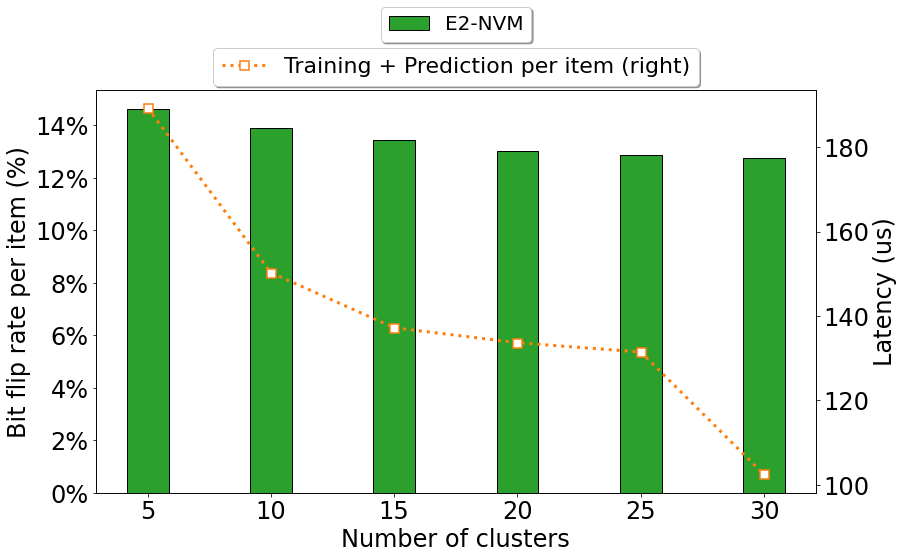

<Figure size 432x288 with 0 Axes>

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

a1 = 'E2-NVM'
a2 = 'Training + Prediction per item'


font = 24
width = .34 # width of a bar

m1_t = pd.DataFrame({
 a1 : TF_y_cluster,
 a2 : Total_time})




fig = plt.figure(figsize=(8,10))
ax1 = plt.axes((0.1,0.1,0.8,0.8))

m1_t[[a1]].plot(kind='bar', width = width ,ax=ax1,fontsize=24, color = ['#2ca02c'],edgecolor='k')
m1_t[a2].plot(secondary_y=True, marker = 's', linestyle='dotted', linewidth=3, markerfacecolor='w', markeredgewidth=1.5, markersize=9, color='#ff7f0e')


ax = plt.gca()
ax.figure.set_size_inches(12.5, 7)



ax.set_xticklabels([str(i) for i in cluster_range])

ax.tick_params(axis='both', which='major', labelsize=24)

leg = ax.legend(loc='upper right', fontsize=18)
for line in leg.get_lines():
    line.set_linewidth(4.0)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13),
          ncol=3, fancybox=True, shadow=True, fontsize=22)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.23),
          ncol=3, fancybox=True, shadow=True, fontsize=20)

# manipulate
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

ax1.set_ylabel('Bit flip rate per item (%)', fontsize=font)
ax.set_ylabel('Latency (us)', fontsize=font)
ax1.set_xlabel('Number of clusters', fontsize=font)

plt.show()
plt.savefig('line_plot.pdf')  